/tmp/ipykernel_93401/664027022.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


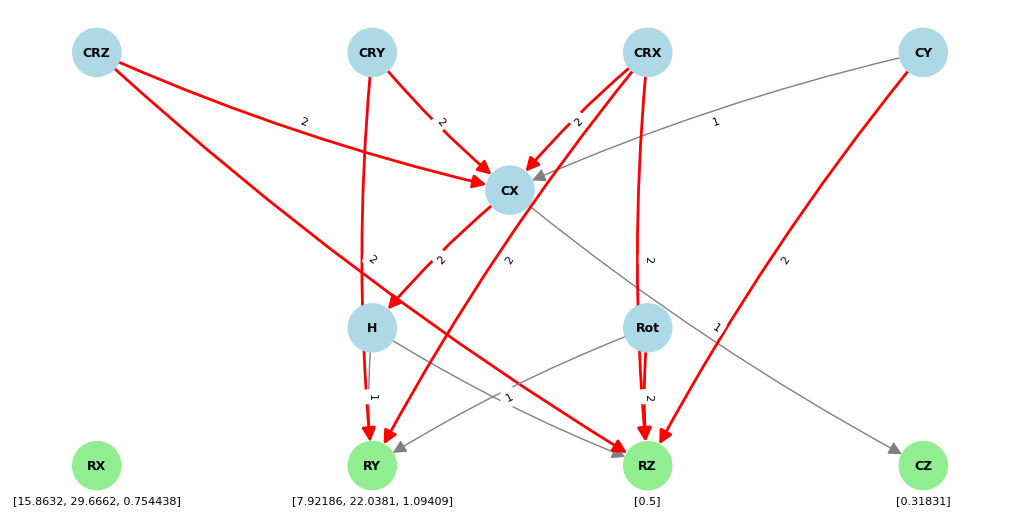

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from qml_essentials.ansaetze import PulseParams
from qml_essentials.gates import PulseInformation as pinfo


def build_pulse_graph(root: PulseParams) -> nx.DiGraph:
    """
    Build a directed graph of PulseParams dependencies.
    Nodes: PulseParams instances.
    Edges: parent -> child, with 'weight' being multiplicity.
    Node attributes:
        - 'name': gate name
        - 'params': string with parameters ('' for non-leaf)
        - 'is_leaf': bool
    Edge attributes:
        - 'weight': int
    """
    G = nx.DiGraph()

    stack = [root]
    visited = set()

    while stack:
        node = stack.pop()
        if node in visited:
            continue
        visited.add(node)

        # Node attributes
        if node.is_leaf:
            params_str = ", ".join(f"{float(x):.6g}" for x in node._params)
        else:
            params_str = ""

        if node not in G:
            G.add_node(
                node,
                name=node.name,
                params=params_str,
                is_leaf=node.is_leaf,
            )

        if not node.is_leaf:
            counts = {}
            for child in node.childs:
                counts[child] = counts.get(child, 0) + 1

            for child, w in counts.items():
                if G.has_edge(node, child):
                    G[node][child]["weight"] += w
                else:
                    G.add_edge(node, child, weight=w)

                if child not in visited:
                    stack.append(child)

    return G

def compute_leaf_distances(G: nx.DiGraph):
    """
    For each node, compute the maximum distance (in edges) to any leaf below it.
    This makes nodes with longer dependency chains appear higher in the tree.
    """
    # distance_to_leaf[node] = 0 for leaves
    distance_to_leaf = {n: 0 for n, d in G.nodes(data=True) if d.get("is_leaf")}

    # Process nodes in reverse topological order
    for n in reversed(list(nx.topological_sort(G))):
        if G.out_degree(n) == 0:
            continue  # leaf already has distance 0
        # max(1 + child distance)
        child_dists = [1 + distance_to_leaf[c] for c in G.successors(n)]
        distance_to_leaf[n] = max(child_dists)

    return distance_to_leaf

def hierarchical_pos_from_leaf_distance(G: nx.DiGraph, scale_x=1.0, scale_y=1.0):
    """
    Construct a 'tree-like' layout where:
      - y is proportional to distance from leaf (nodes with longest chains higher up)
      - x spreads siblings to avoid overlap.
    """
    # Compute "height" = distance from leaf
    dist = compute_leaf_distances(G)
    max_h = max(dist.values()) if dist else 0

    # Group nodes by height
    layers = {}
    for n, h in dist.items():
        layers.setdefault(h, []).append(n)

    # Assign x within each layer equally spaced
    pos = {}
    for h, nodes in sorted(layers.items()):  # from 0 (leaves) up
        k = len(nodes)
        if k == 1:
            xs = [0.0]
        else:
            xs = [i - (k - 1) / 2 for i in range(k)]
        for n, x in zip(nodes, xs):
            # y = h, with leaves at y=0, more complex gates higher (larger h)
            pos[n] = (x * scale_x, h * scale_y)

    return pos

def draw_pulse_graph(G: nx.DiGraph, figsize=(10, 5)):
    # Our custom hierarchical layout instead of graphviz/spring
    pos = hierarchical_pos_from_leaf_distance(G, scale_x=1.5, scale_y=1)

    plt.figure(figsize=figsize)

    # Node colors: leaf vs non-leaf
    node_colors = [
        "lightgreen" if G.nodes[n].get("is_leaf") else "lightblue"
        for n in G.nodes
    ]

    # Edge widths proportional to weight
    edge_weights = [G[u][v].get("weight", 1) for u, v in G.edges]
    max_w = max(edge_weights) if edge_weights else 1
    widths = [1 + 2 * (w - 1) / max_w for w in edge_weights]

    # Edge colors: highlight edges with weight > 1
    edge_colors = [
        "red" if G[u][v].get("weight", 1) > 1 else "gray"
        for u, v in G.edges
    ]

    # Draw nodes and edges
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_color=node_colors,
        node_size=1200,
        width=widths,
        edge_color=edge_colors,
        arrows=True,
        arrowsize=20,
        connectionstyle="arc3,rad=0.05",
    )

    # 1) Gate name labels (center of node)
    name_labels = {n: G.nodes[n]["name"] for n in G.nodes}
    nx.draw_networkx_labels(G, pos, labels=name_labels, font_size=9, font_weight="bold")

    # 2) Parameter labels, slightly below each node
    param_labels = {
        n: f"[{G.nodes[n]['params']}]" if G.nodes[n]["params"] else ""
        for n in G.nodes
    }
    # Shift y coordinate down a bit for params
    offset_pos = {n: (x, y - 0.25) for n, (x, y) in pos.items()}
    nx.draw_networkx_labels(G, offset_pos, labels=param_labels, font_size=8)

    # Edge labels: show weight if > 1
    edge_labels = {
        (u, v): G[u][v]["weight"]
        for u, v in G.edges
        if G[u][v].get("weight", 1)
    }
    

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Build global graph as before
top_roots = [pinfo.RX, pinfo.RY, pinfo.RZ, pinfo.CZ, pinfo.H, pinfo.CX, pinfo.CY, pinfo.CRX, pinfo.CRY, pinfo.CRZ, pinfo.Rot]
G = nx.DiGraph()
for root in top_roots:
    Gi = build_pulse_graph(root)
    G = nx.compose(G, Gi)

draw_pulse_graph(G)

In [2]:
gate = "CX"

print(f"Number of pulse parameters for {gate}: {pinfo.num_params(gate)}")

gate_instance = pinfo.gate_by_name(gate)

print(f"Childs of {gate}: {gate_instance.childs}")

print(f"All parameters of {gate}: {gate_instance.params}")

print(f"Leaf parameters of {gate}: {len(gate_instance.leaf_params)}")

Number of pulse parameters for CX: 9
Childs of CX: [H, CZ, H]
All parameters of CX: [ 0.5         7.9218643  22.0381298   1.09409231  0.31830953  0.5
  7.9218643  22.0381298   1.09409231]
Leaf parameters of CX: 5


In [3]:
import pennylane.numpy as np
from qml_essentials.model import Model


model = Model(n_layers=1, n_qubits=2, circuit_type="Circuit_19")

print(f"Shape of pulse parameters: {model.pulse_params.shape}")

res_a = model(gate_mode="pulse", pulse_params=model.pulse_params * 1.00)
res_b = model(gate_mode="pulse", pulse_params=model.pulse_params * 1.01)

print(f"Difference: {res_a - res_b}")

Shape of pulse parameters: (2, 60)


/home/lc3267/Documents/CodeWorkspace/qml-essentials/.venv/lib/python3.11/site-packages/pennylane/math/interface_utils.py:127: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/home/lc3267/Documents/CodeWorkspace/qml-essentials/.venv/lib/python3.11/site-packages/pennylane/math/interface_utils.py:127: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Difference: [ 0.03300281 -0.01667439]


In [4]:
from qml_essentials.qoc import QOC
import csv
import matplotlib.pyplot as plt

qoc = QOC()
n_loops = qoc.n_loops
n_steps = qoc.n_steps
n_samples = qoc.n_samples

# optimize(gate="all", loops=5, make_log=True)

qoc_results = {}
with open("../qml_essentials/qoc_results.csv", "r") as f:
    reader = csv.reader(f)

    for row in reader:
        qoc_results[row[0]] = [float(x) for x in row[2:]]

qoc_logs = {}
with open("../qml_essentials/qoc_logs.csv", "r") as f:
    reader = csv.DictReader(f)
    qoc_logs = {field: [] for field in reader.fieldnames}

    for row in reader:
        for field in reader.fieldnames:
            val = float(row[field])
            qoc_logs[field].append(val)


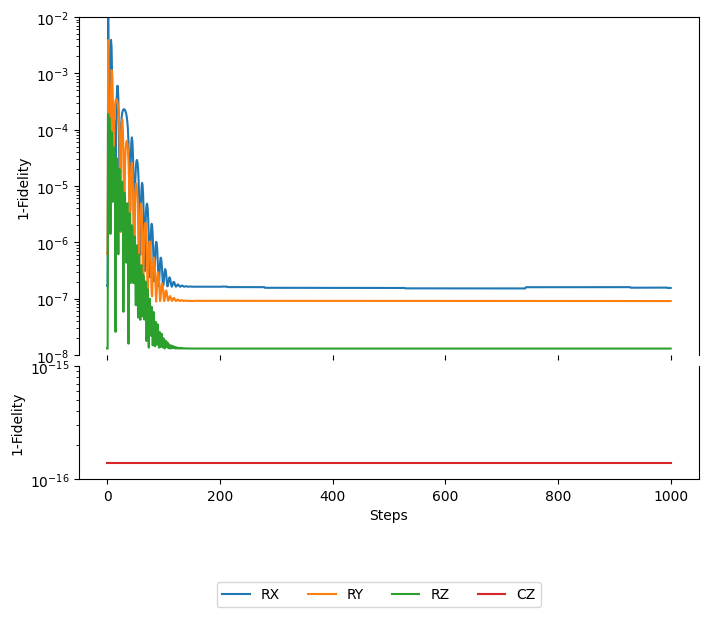

In [5]:
# choose the limits for the two segments (adjust to your needs)
top_ylim = (1e-8, 1e-2)     # values above the break
bottom_ylim = (1e-16, 1e-15)  # values below the break

fig = plt.figure(figsize=(8, 6))
# two vertically stacked axes, small gap (hspace controls spacing)
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
ax_top = fig.add_subplot(gs[0])
ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)

# Plot the same data on both axes
for gate, fidelities in qoc_logs.items():
    ax_top.plot(fidelities, label=gate)
    ax_bottom.plot(fidelities, label=gate)

# log scale and limits
ax_top.set_yscale("log")
ax_bottom.set_yscale("log")
ax_top.set_ylim(top_ylim)
ax_bottom.set_ylim(bottom_ylim)

# labels
ax_bottom.set_xlabel("Steps")
ax_top.set_ylabel("1-Fidelity")
ax_bottom.set_ylabel("1-Fidelity")

# hide the spines between the two axes
ax_top.spines['bottom'].set_visible(False)
ax_bottom.spines['top'].set_visible(False)
ax_top.tick_params(labelbottom=False)  # hide x labels on top


# single legend for the figure (collect from one axis)
handles, labels = ax_top.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=False, ncol=5)

plt.show()

In [6]:
from qml_essentials.gates import PulseInformation
import pennylane as qml
import jax
from jax import numpy as jnp
jax.config.update("jax_enable_x64", True)

single_q_gates = ["RX", "RY", "RZ", "H", "Rot"]
dual_q_gates = ["CRX", "CRY", "CRZ"]

# read-back optimized pulse parameters if necessary
# PulseInformation.update_params("../qml_essentials/qoc_results.csv")

# parameters sweeping
start = 0
stop = 2 * jnp.pi
inc = (2 * jnp.pi) / n_samples

def compute_fidelity_and_phase(dev, gate):
    pulse_circuit, target_circuit = getattr(qoc, "create_" + gate)()

    pulse_qnode = qml.QNode(pulse_circuit, dev, interface="jax")
    target_qnode = qml.QNode(target_circuit, dev, interface="jax")

    results[gate] = {"fidelity":[], "phase":[]}

    ws = jnp.arange(start, stop+inc, inc)
    for i, w in enumerate(ws): 
        print(f"\rSimulating {gate} gate - Parameter sweep {i+1}/{n_samples+1}", end="")

        state_pulse = pulse_qnode(w, PulseInformation.gate_by_name(gate).params)
        state_target = target_qnode(w)

        results[gate]["fidelity"].append(float(jnp.abs(jnp.vdot(state_target, state_pulse)) ** 2))
        results[gate]["phase"].append(float(jnp.abs(1-jnp.angle(jnp.vdot(state_target, state_pulse)))))
    print("")

results = {}
dev = qml.device("default.qubit", wires=1)
for gate in single_q_gates:
    compute_fidelity_and_phase(dev, gate)

dev = qml.device("default.qubit", wires=2)
for gate in dual_q_gates:
    compute_fidelity_and_phase(dev, gate)

Simulating RX gate - Parameter sweep 9/9
Simulating RY gate - Parameter sweep 9/9
Simulating RZ gate - Parameter sweep 9/9
Simulating H gate - Parameter sweep 9/9
Simulating Rot gate - Parameter sweep 9/9
Simulating CRX gate - Parameter sweep 9/9
Simulating CRY gate - Parameter sweep 9/9
Simulating CRZ gate - Parameter sweep 9/9


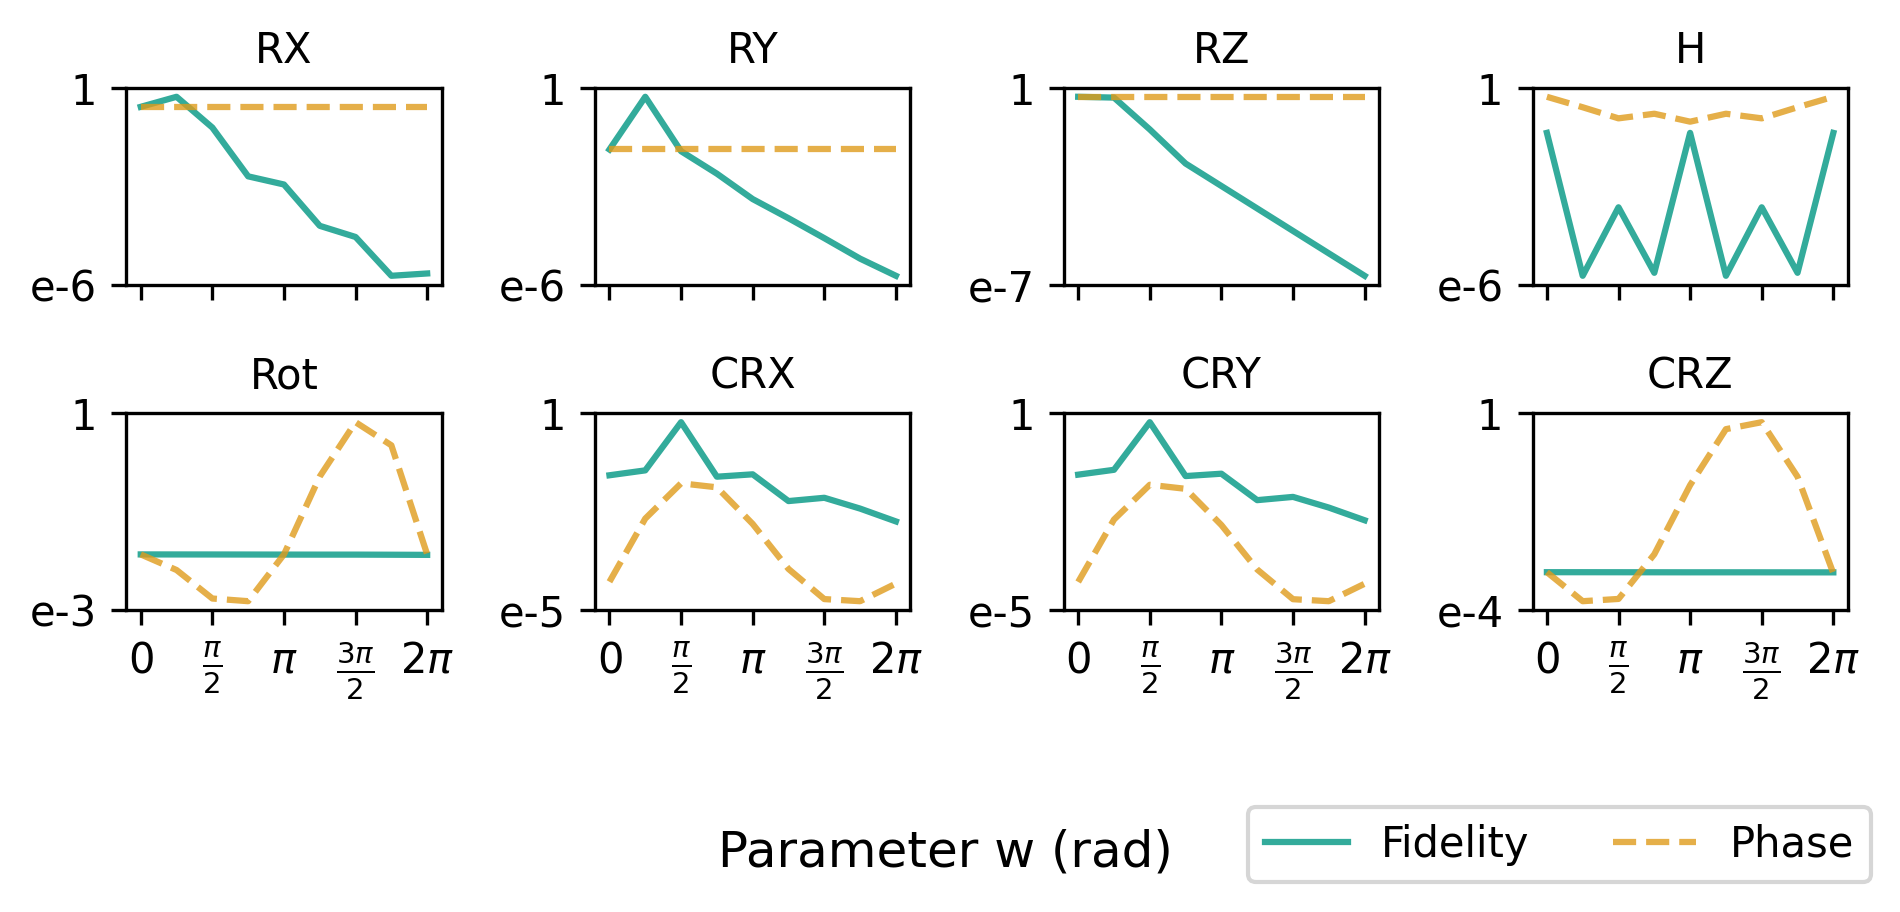

In [34]:
import numpy as np
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

def x_for_value(v, eps=1e-12):
    """Return largest integer x with 1 - 10**(-x) <= v.
       If v >= 1, returns math.inf. If v <= 0, returns 0.
    """
    if v >= 1.0:
        return float("inf")
    if v <= 0.0:
        return 0
    d = 1.0 - v
    x = math.floor(-math.log10(d) + eps)
    return int(x)

def representable_by_x(x):
    if x == float("inf"):
        return 1.0
    return 1.0 - 10.0**(-x)


mpl.rcParams['figure.dpi'] = 300

gates = single_q_gates + dual_q_gates 
ws = jnp.arange(start, stop + inc, inc)
n_gates = len(gates)

ncols = 4
nrows = int(np.ceil(n_gates / ncols)) 
fig, axs = plt.subplots(nrows, ncols, sharex=True)
axs = axs.flatten()

w, h = fig.get_size_inches()
fig.set_size_inches(w, nrows * 1.5)

for i, gate in enumerate(gates):
    ax = axs[i]
    colors = iter(["#009682", "#DF9B1B"])
    styles = iter(["-", "--"])

    for name, feature in results[gate].items():
        ax.plot(
            ws, feature,
            label=f"{name.title()}",
            linestyle=next(styles),
            color=next(colors),
            alpha=0.8
        )

    ax.set_title(str(gate), fontsize=10)
    ax.set_yscale("log")

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(bottom=ymin, top=ymax)

    ax.set_yticks([ymax, ymin])
    ax.set_yticklabels(["1", f"e-{x_for_value(ymin)}"]) #{ymin:.7f}
    ax.yaxis.set_minor_locator(mticker.NullLocator())

# x ticks on bottom row only
xticks = np.arange(0, 2 * np.pi + 0.1, np.pi / 2)
xtick_labels = [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]

for r in range(nrows):
    for c in range(ncols):
        idx = r * ncols + c
        if idx >= n_gates:
            continue
        ax = axs[idx]
        if r == nrows - 1:
            ax.set_xticks(xticks)
            ax.set_xticklabels(xtick_labels)
        else:
            ax.set_xticklabels([])

# figure-level x label
fig.supxlabel("Parameter w (rad)")

# centered figure-level legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.82, -0.02),
    ncol=2,
    fancybox=True,
    shadow=False
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
# plt.savefig("gates_plot.pdf", bbox_inches="tight")
plt.savefig("figures/gates_fidelities_light.png", dpi=200, transparent=True)
plt.show()